In [ ]:
# Importing necessary libraries
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL
from PIL import Image
import os

In [ ]:
# Setting up the device for torch to use CUDA (NVIDIA GPU) if available, for faster computation
device = torch.device("cuda")

In [ ]:
def get_sample_image(root_dir=r"C:\Users\uchit\OneDrive\Desktop\Datasets\MPM_Part04_L0001"):
    """
    Loads the first image from the specified directory.

    Args:
        root_dir (str, optional): Path to the directory containing images. Defaults to a specific path on the user's desktop.

    Returns:
        PIL.Image.Image: The first image in the directory.
    """
    # Create a list of filenames in the directory that end with '.bmp' (bitmap image file)
    image_names = [f for f in os.listdir(root_dir) if f.endswith(".bmp")]
    
    # Check if no images were found in the directory; if so, raise an error
    if not image_names:
        raise ValueError("No images found in the specified directory.")
    
    # Construct the full path to the first image in the list
    image_path = os.path.join(root_dir, image_names[0])
    
    # Open and return the image using PIL's Image module
    return Image.open(image_path)


In [ ]:
def plot_noise_distribution(noise, predicted_noise):
    """
    Plots histograms of actual and predicted noise distributions.

    Args:
        noise (torch.Tensor): A tensor containing the ground truth noise data.
        predicted_noise (torch.Tensor): A tensor containing the predicted noise data.

    """
    # Convert the ground truth noise tensor from PyTorch to a NumPy array and flatten it for plotting
    plt.hist(noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="ground truth noise")

    # Convert the predicted noise tensor from PyTorch to a NumPy array and flatten it for plotting
    plt.hist(predicted_noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="predicted noise")

    # Display the legend to differentiate between ground truth and predicted noise
    plt.legend()

    # Display the histogram plot
    plt.show()


In [ ]:
def plot_noise_prediction(noise, predicted_noise):
    """
    Plots side-by-side comparison of actual and predicted noise images.

    Args:
        noise (torch.Tensor): A tensor containing the ground truth noise data.
        predicted_noise (torch.Tensor): A tensor containing the predicted noise data.
    """
    # Initialize a larger figure to place subplots
    plt.figure(figsize=(15,15))

    # Create a subplot grid of 1 row by 2 columns, each subplot having a size of 5x5
    f, ax = plt.subplots(1, 2, figsize = (5,5))

    # Display the ground truth noise image in the first subplot
    ax[0].imshow(reverse_transform(noise))
    # Set the title of the first subplot
    ax[0].set_title("ground truth noise", fontsize = 10)

    # Display the predicted noise image in the second subplot
    ax[1].imshow(reverse_transform(predicted_noise))
    # Set the title of the second subplot
    ax[1].set_title("predicted noise", fontsize = 10)

    # Show the plot with both subplots
    plt.show()


In [ ]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps=100):
        """
        Initializes the Diffusion Model with a schedule for the beta values and the number of timesteps.

        Args:
            start_schedule (float): Initial value for the beta schedule.
            end_schedule (float): Final value for the beta schedule.
            timesteps (int): Number of timesteps in the diffusion process.
        """
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        # Linearly spaced beta values from start to end schedule over the number of timesteps
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        # Alpha values are calculated as 1 minus the corresponding beta values
        self.alphas = 1 - self.betas
        # Cumulative product of alpha values to compute the variance decay over time
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device):
        """
        Forward pass to simulate the diffusion process from the data x_0 at time t.

        Args:
            x_0 (torch.Tensor): Original data (images).
            t (torch.Tensor): Timestep indices.
            device (torch.device): Device to run the computations on.

        Returns:
            tuple: Tuple containing the noised data and the added noise.
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Backward pass to reverse the diffusion process, aiming to denoise the image.

        Args:
            x (torch.Tensor): Noised data.
            t (torch.Tensor): Timestep indices.
            model (callable): The model used to estimate the original noise in the data.
            **kwargs: Additional arguments to the model.

        Returns:
            torch.Tensor: The estimated denoised image or further noised image if not at the last step.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        """
        Utility method to extract values from a tensor based on indices.

        Args:
            values (torch.Tensor): Tensor from which values are to be extracted.
            t (torch.Tensor): Indices for values to extract.
            x_shape (tuple): Shape of the output tensor.

        Returns:
            torch.Tensor: Reshaped tensor with values selected according to t.
        """
        batch_size = t.shape[0]
        result = values.gather(-1, t.cpu())
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


In [ ]:
# Define a constant tuple for the dimensions of images used in the model, set to 64x64 pixels
IMAGE_SHAPE = (64, 64)

# Clear unused memory from the GPU to optimize performance and resource management
torch.cuda.empty_cache()


In [ ]:
def scale_pixels(t):
    """
    Scales the pixel values from [0, 1] to [-1, 1].

    Args:
        t (torch.Tensor): Tensor containing pixel values in range [0, 1].

    Returns:
        torch.Tensor: Tensor with pixel values scaled to range [-1, 1].
    """
    return (t * 2) - 1

# Transformation pipeline for preprocessing images
transform = transforms.Compose([
    transforms.Resize((IMAGE_SHAPE)),        # Resizes the image to the specified dimensions (64, 64)
    transforms.ToTensor(),                   # Converts images to PyTorch tensors and scales pixel values to [0, 1]
    transforms.Lambda(scale_pixels)          # Scales pixel values from [0, 1] to [-1, 1]
])

# Transformation pipeline for postprocessing images
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),                # Rescales tensors from [-1, 1] back to [0, 1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)),         # Rearranges the tensor dimensions from CHW (Channels, Height, Width)
                                                             # format to HWC (Height, Width, Channels)
    transforms.Lambda(lambda t: t * 255.),                   # Scales pixel values from [0, 1] to [0, 255]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),  # Moves the tensor to CPU, converts it to a NumPy array,
                                                                    # and changes the data type to unsigned 8-bit integer
    transforms.ToPILImage()                                  # Converts the NumPy array to a PIL image for display or saving
])






In [ ]:
# Load an image from the specified directory using the get_sample_image function
pil_image = get_sample_image()

# Apply the predefined transformations to the PIL image to convert it into a PyTorch tensor suitable for model input
torch_image = transform(pil_image)


In [ ]:
# Initialize the DiffusionModel instance with default scheduling parameters for beta values and number of timesteps
diffusion_model = DiffusionModel()

<Figure size 1500x1500 with 0 Axes>

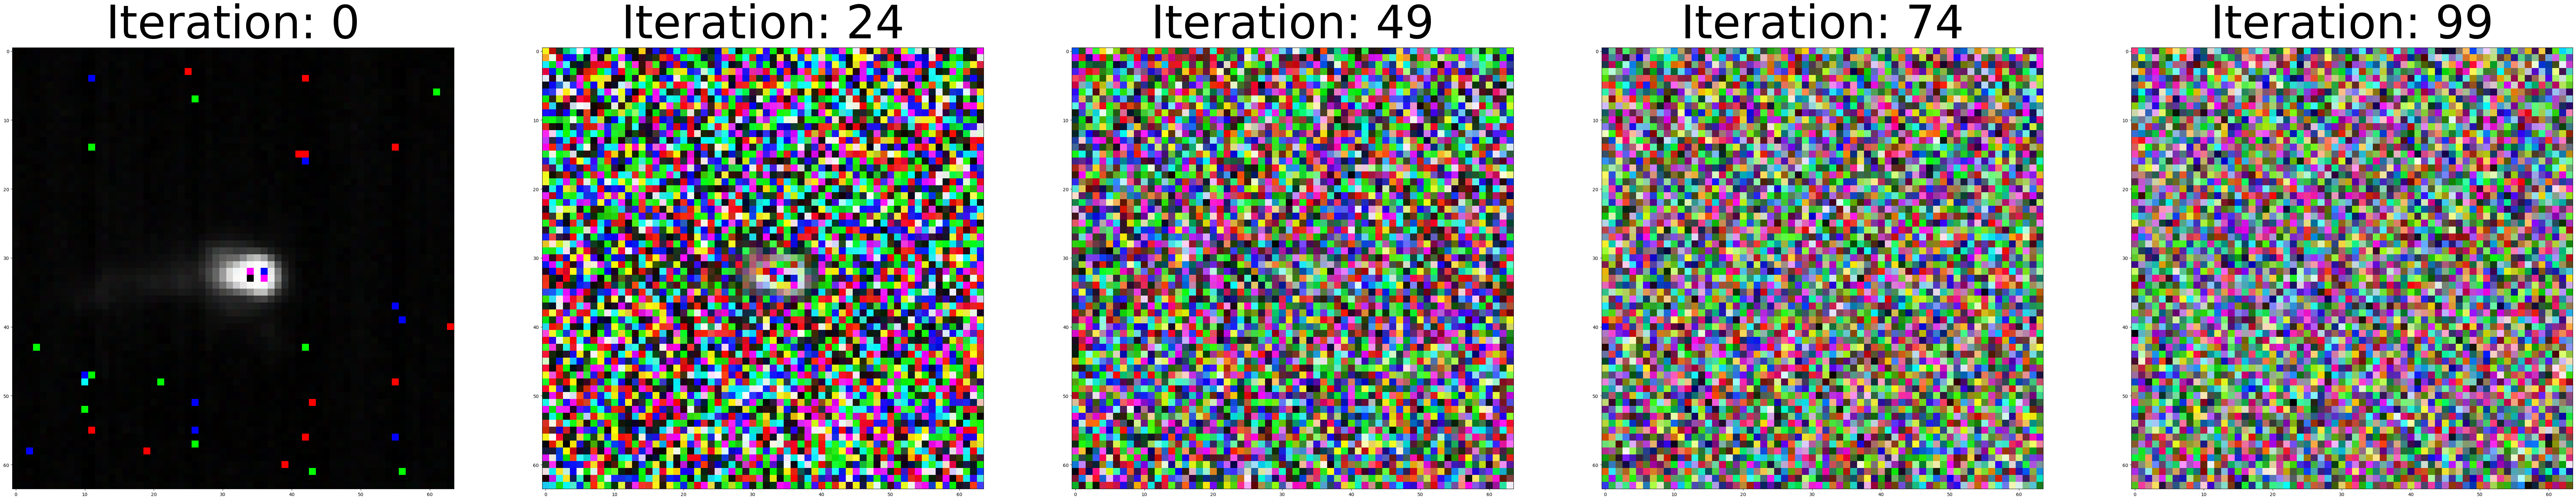

In [ ]:
# Define the number of images to display
NO_DISPLAY_IMAGES = 5

# Create a batch of identical images by stacking the transformed image multiple times
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)

# Generate linearly spaced time steps from 0 to the last timestep, converting to long datatype
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()

# Generate a batch of noisy images using the forward method of the diffusion model
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

# Set up a large figure to display the images
plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))  # Note: figsize might be excessively large for practical purposes

# Loop through each image in the batch and display it
for idx, image in enumerate(noisy_image_batch):
    # Reverse the transformation applied to the noisy image to make it displayable
    ax[idx].imshow(reverse_transform(image))
    # Set the title of each subplot to show the iteration number
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
# Show the plot with all images
plt.show()


In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        """
        Initializes the SinusoidalPositionEmbeddings module.

        Args:
            dim (int): The dimensionality of the embeddings.
        """
        super().__init__()
        self.dim = dim  # Store the dimension of the embeddings

    def forward(self, time):
        """
        Generates sinusoidal position embeddings based on input time indices.

        Args:
            time (torch.Tensor): A tensor of shape [batch_size] containing the time indices.

        Returns:
            torch.Tensor: A tensor of shape [batch_size, dim] containing the sinusoidal embeddings.
        """
        device = time.device  # Retrieve the device from the input tensor to ensure consistency
        half_dim = self.dim // 2  # Compute half of the dimensions to separate sin and cos components

        # Calculate the logarithmic scaling factor inversely proportional to the dimension
        embeddings = math.log(10000) / (half_dim - 1)
        # Generate the scaling factors for each dimension
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

        # Scale the time indices by the computed factors
        embeddings = time[:, None] * embeddings[None, :]
        # Calculate the sinusoidal embeddings by applying the sin and cos functions
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


In [ ]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters=3, downsample=True):
        """
        Initializes the Block module which may conditionally downsample or upsample, and integrates label and time embeddings.

        Args:
            channels_in (int): Number of input channels.
            channels_out (int): Number of output channels.
            time_embedding_dims (int): Dimensionality of the time embeddings.
            labels (bool): Whether label conditioning is used.
            num_filters (int, optional): Size of the convolution kernel. Defaults to 3.
            downsample (bool, optional): Whether to downsample the input. Defaults to True.
        """
        super().__init__()

        # Store the time embedding dimensions and create a sinusoidal time embedding module
        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        
        # Handle label-based conditioning
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)  # MLP for processing labels

        # Set up the convolution operations for either downsampling or upsampling
        self.downsample = downsample
        if downsample:
            # Standard convolution followed by a downsampling convolution
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            # For upsampling scenarios, use transpose convolutions
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        # Batch normalization layers
        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        # Second standard convolution layer
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        # Linear transformation for processing time embeddings
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        """
        Forward pass of the Block, applying convolutions, normalizations, and incorporating time and label embeddings.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Tensor containing time indices for embeddings.
            **kwargs: Keyword arguments that may include labels for conditional generation.

        Returns:
            torch.Tensor: The output tensor after applying the block operations.
        """
        # Apply convolution, ReLU, and batch normalization
        o = self.bnorm1(self.relu(self.conv1(x)))
        # Compute time embeddings and apply the corresponding MLP
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        # Add time-conditioned information to the output
        o = o + o_time[(..., ) + (None, ) * 2]

        # If label conditioning is enabled, process labels and add to the output
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        # Apply second convolution, ReLU, and batch normalization
        o = self.bnorm2(self.relu(self.conv2(o)))

        # Final convolution, potentially downscaling or upscaling
        return self.final(o)


In [ ]:
class UNet(nn.Module):
    def __init__(self, img_channels=1, time_embedding_dims=128, labels=False, sequence_channels=(64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)

    
    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)
            
        return self.conv2(o)

In [ ]:
# Define training hyperparameters
NO_EPOCHS = 1600  # Total number of epochs to train the model
PRINT_FREQUENCY = 400  # Frequency of printing the training progress
LR = 0.001  # Learning rate for the optimizer
BATCH_SIZE = 64  # Number of samples in each batch
VERBOSE = True  # Flag to control the output of training progress messages

# Initialize the UNet model without label conditioning
unet = UNet(labels=False)

# Move the model to the appropriate device (GPU or CPU)
unet.to(device)

# Initialize the optimizer, using the Adam algorithm with the defined learning rate
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)


---
Epoch: 0 | Train Loss 1.0361381769180298


<Figure size 1500x1500 with 0 Axes>

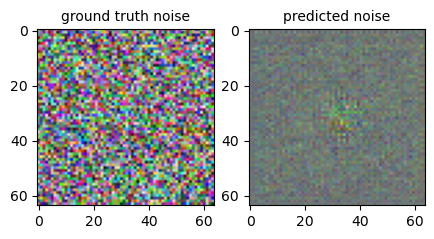

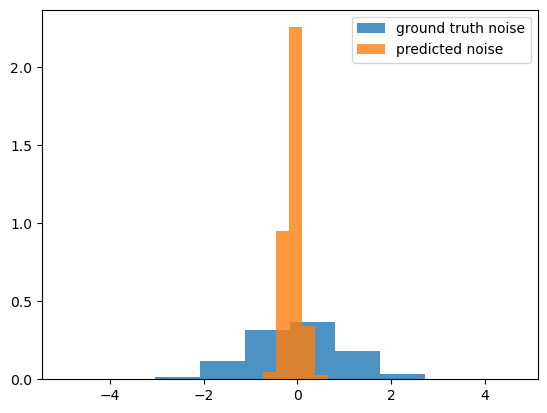

---
Epoch: 400 | Train Loss 0.015971068292856216


<Figure size 1500x1500 with 0 Axes>

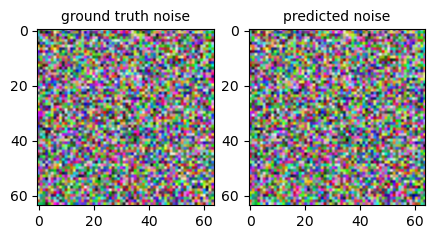

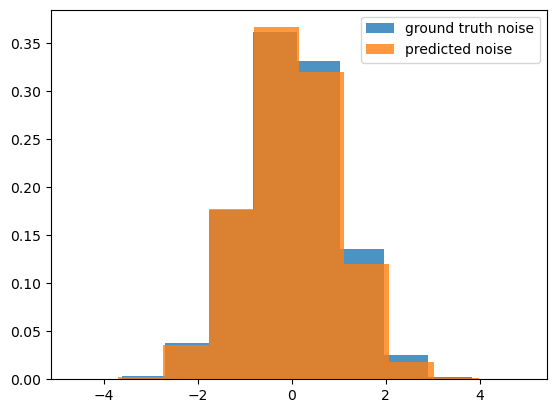

---
Epoch: 800 | Train Loss 0.007613970898091793


<Figure size 1500x1500 with 0 Axes>

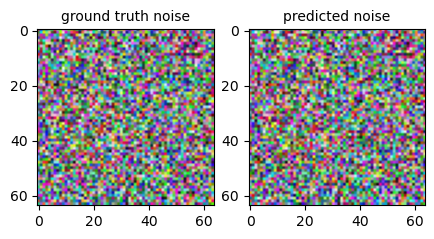

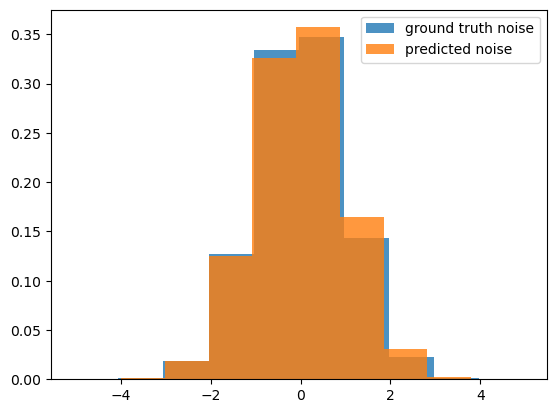

---
Epoch: 1200 | Train Loss 0.00628010556101799


<Figure size 1500x1500 with 0 Axes>

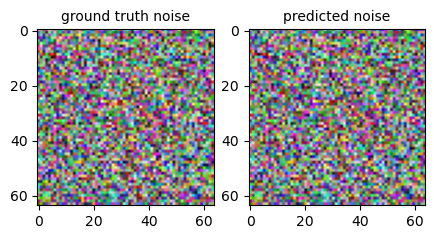

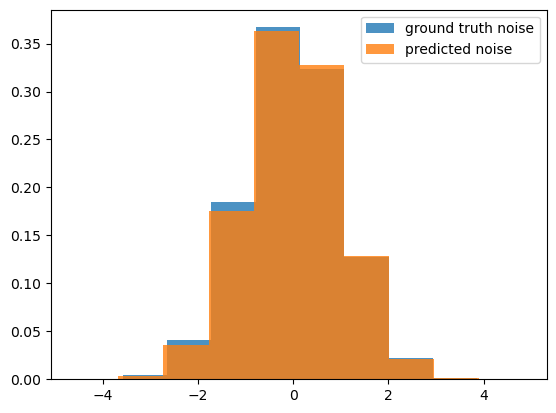

In [ ]:
# Iterate through the specified number of epochs
for epoch in range(NO_EPOCHS):
    # List to store loss values for each batch within the epoch to calculate mean loss later
    mean_epoch_loss = []

    # Simulate a batch of images; typically, you would load actual batches from a dataset here
    batch = torch.stack([torch_image] * BATCH_SIZE)

    # Randomly sample time steps for each item in the batch
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    # Generate noisy images using the diffusion model
    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    # Predict noise from noisy images using the UNet
    predicted_noise = unet(batch_noisy, t)

    # Reset gradients to zero before starting backpropagation to prevent accumulation from previous iterations
    optimizer.zero_grad()

    # Calculate the mean squared error loss between the true noise and the predicted noise
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())

    # Perform backpropagation
    loss.backward()

    # Adjust model weights
    optimizer.step()

    # Output training progress information
    if epoch % PRINT_FREQUENCY == 0:
        # Calculate and print the mean loss for the epoch
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")

        # If verbose is enabled, visualize the noise prediction and distribution
        if VERBOSE:
            with torch.no_grad():  # Perform operations without tracking gradients
                # Visualize the first noise prediction comparison
                plot_noise_prediction(noise[0], predicted_noise[0])
                # Visualize the noise distribution for the batch
                plot_noise_distribution(noise, predicted_noise)


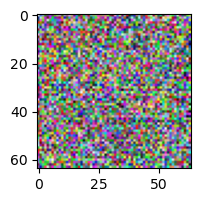

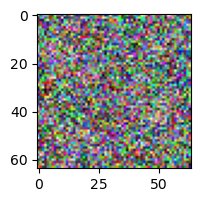

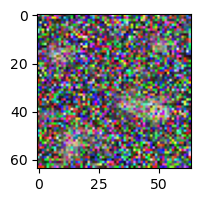

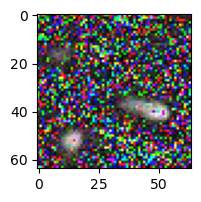

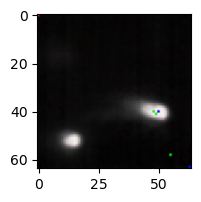

In [ ]:
# Context manager to stop autograd from tracking tensor histories
with torch.no_grad():
    # Initialize a random noise image as the starting point
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    
    # Iteratively apply the backward process of the diffusion model to synthesize the image
    for i in reversed(range(diffusion_model.timesteps)):
        # Create a tensor full of the current timestep index
        t = torch.full((1,), i, dtype=torch.long, device=device)
        
        # Perform the backward step of the diffusion process using the UNet to predict the noise
        # Here, the UNet is in evaluation mode to disable dropout, batch norm updates etc.
        img = diffusion_model.backward(img, t, unet.eval())
        
        # Optionally, visualize the image at certain timesteps
        if i % 20 == 0:
            plt.figure(figsize=(2,2))  # Create a small figure for the image
            plt.imshow(reverse_transform(img[0]))  # Transform and display the image
            plt.axis('off')  # Hide the axis
            plt.show()
